In [365]:
import pandas as pd
import numpy as np
import sklearn as sk
from urllib.request import urlopen
import json   
import matplotlib.pyplot as plt
from pylab import rcParams

### Getting training data

In [340]:
MP_json_dir = "../data/training/materialsproject_json"

training_compounds = [
    "Si",
    "Ge",
    "SiGe",
]

In [341]:
training_data = dict()
for training_compound in training_compounds:
    with open(f"{MP_json_dir}/{training_compound}.json") as fname:
        training_compound_results = dict(json.load(fname))
        for ID, training_compound_result in training_compound_results.items():
            training_data[ID] = training_compound_result

In [342]:
training_data_IDs = list(training_data.keys())

In [343]:
training_data[training_data_IDs[-1]]

{'formula': 'Si3Ge',
 'spacegroup': 'Fm3m',
 'formation_energy__eV': 0.525,
 'E_above_hull__eV': 0.525,
 'band_gap__eV': 0.0,
 'has_bandstructure': True,
 'volume': 63.538999999999994,
 'Nsites': 4,
 'theoretical': True,
 'count': nan,
 'density__gm_per_cc': 4.1,
 'crystal_system': 'cubic'}

### Extract stoichiometry for each result

In [344]:
def get_stoichiomertry(formula):
    symbols = []
    stoichiometry = dict()
    for ii in range(len(formula)-1):
        item_ii = formula[ii]
        item_jj = formula[ii+1]
        if item_ii.isupper() and item_jj.islower():
            symbols.append((ii,formula[ii:ii+2]))
                        
    for ii in range(len(symbols)):
        start_slc = symbols[ii][0]+2
        if ii < len(symbols)-1:
            end_slc = symbols[ii+1][0]
            tmp_value = formula[start_slc:symbols[ii+1][0]]
        else:
            tmp_value = formula[start_slc:]
        stoichiometry[symbols[ii][1]] = int(tmp_value) if len(tmp_value) != 0 else 1
        
    return stoichiometry

def get_norm_stoichiomertry(formula):
    stoichiometry = get_stoichiomertry(formula)
    num_atoms = [ atoms for (element, atoms) in stoichiometry.items() ]
    num_atoms_total = sum(num_atoms)
    norm_stoichiometry = { element:atoms/num_atoms_total for (element, atoms) in stoichiometry.items()} 
    return norm_stoichiometry

In [345]:
for ID, result in training_data.items():
    norm_stoichiometry = get_norm_stoichiomertry(result["formula"])
    training_data[ID]["stoichiometry"] = norm_stoichiometry

In [346]:
training_data[training_data_IDs[-1]]

{'formula': 'Si3Ge',
 'spacegroup': 'Fm3m',
 'formation_energy__eV': 0.525,
 'E_above_hull__eV': 0.525,
 'band_gap__eV': 0.0,
 'has_bandstructure': True,
 'volume': 63.538999999999994,
 'Nsites': 4,
 'theoretical': True,
 'count': nan,
 'density__gm_per_cc': 4.1,
 'crystal_system': 'cubic',
 'stoichiometry': {'Si': 0.75, 'Ge': 0.25}}

### Create a simple dataframe 
The dataframe contains the following:
1. Stoichiomery
2. Bandgap
3. Density 
4. Volume
5. Formation energy
6. Proxy for crystal system

In [358]:
# use period table from exabyte.io github:
periodic_table_url = urlopen("https://raw.githubusercontent.com/Exabyte-io/periodic-table.js/master/periodic-table.json")
periodic_table = json.loads(periodic_table_url.read())

symbol_to_element_map = { details["symbol"]:element for (element, details) in periodic_table.items()}
symbols = list(symbol_to_element_map.keys())

In [359]:
# change crystal system to an identification number
crystal_systems = [
    "triclinic",
    "monoclinic",
    "orthorhombic",
    "tetragonal",
    "hexagonal",
    "trigonal",
    "cubic",
]
crystal_system_mapping = dict(zip(crystal_systems, range(0,len(crystal_systems))))

In [360]:
# create new dictionary
training_data_clean = {
    "ID": [],
    "band_gap__eV": [],
    "density__gm_per_cc": [],
    "volume": [],
    "formation_energy__eV": [],
    "crystal_system": [],
}

non_element_data_keys = list(training_data_clean.keys())

# populate the dictionary with keys of all symbols of elements
for symbol in symbols:
    training_data_clean[symbol] = []

# populate the dictionary with the training data
for ID, result in training_data.items():
    training_data_clean["ID"].append(ID)
    
    # Stoichiomery
    elements = list(result["stoichiometry"].keys())   
    for symbol in symbols:
        value = result["stoichiometry"][symbol] if symbol in elements else 0
        training_data_clean[symbol].append(value)
        
    #Bandgap
    training_data_clean["band_gap__eV"].append(result["band_gap__eV"])
    
    #Density
    training_data_clean["density__gm_per_cc"].append(result["density__gm_per_cc"])
    
    #Volume
    training_data_clean["volume"].append(result["volume"])
    
    #Formation energy
    training_data_clean["formation_energy__eV"].append(result["formation_energy__eV"])
    
    #Proxy for crystal system
    crystal_system_identifier = crystal_system_mapping[result["crystal_system"]]
    training_data_clean["crystal_system"].append(crystal_system_identifier)

In [361]:
# create dataframe from dictionary
training_data_clean_df = pd.DataFrame(training_data_clean)

In [362]:
training_data_clean_df.sample(5)

,ID,band_gap__eV,density__gm_per_cc,volume,formation_energy__eV,crystal_system,H,He,Li,Be,...,Mt,Uun,Uuu,Uub,Uut,Uuq,Uup,Uuh,Uus,Uuo
11,mp-1201492,1.011,1.969,5494.177,0.119,6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
56,mp-1094056,0.427,2.689,166.290,0.006,6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47,mp-137,0.873,5.608,258.089,0.238,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31,mp-676011,0.000,2.345,159.131,0.445,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,mp-1199894,0.998,1.997,1915.457,0.127,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


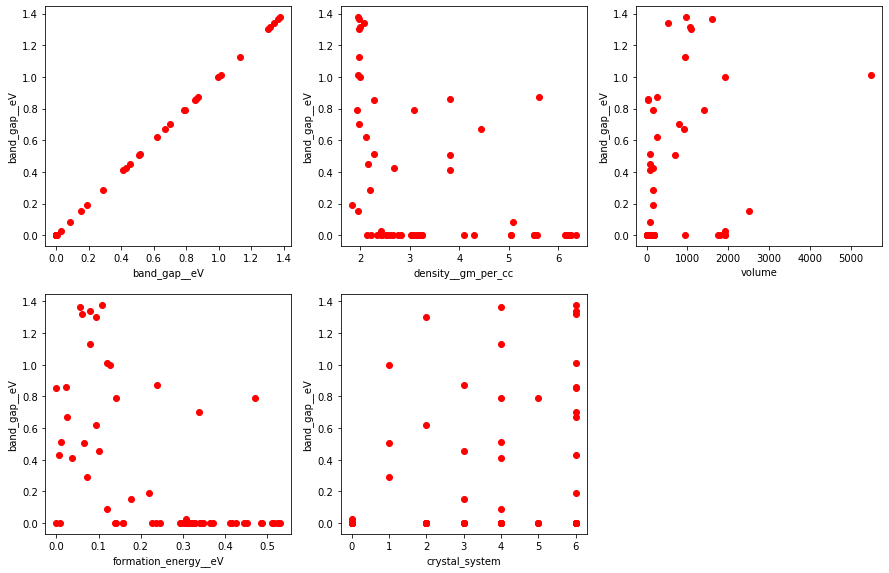

In [374]:
rcParams['figure.figsize'] = 15,15
rows, cols = 3, 3

yaxis = training_data_clean_df['band_gap__eV']
for idx, key in enumerate(non_element_data_keys[1:]):
    xaxis = training_data_clean_df[key]

    plt.subplot(rows,cols,idx+1)
    plt.plot(xaxis, yaxis, "ro")
    plt.xlabel(key)
    plt.ylabel('band_gap__eV')
    
    plt.subplots_adjust(wspace=0.2, hspace=0.2)

In [264]:
sample = training_data[training_data_IDs[-1]]
sample_atoms = list(sample["stoichiometry"].keys())
print(sample_atoms)
sample_atoms_elements = [ symbol_to_element_map[sample_atom] for sample_atom in sample_atoms ]
print(sample_atoms_elements)

['Si', 'Ge']
['Silicon', 'Germanium']


In [267]:
periodic_table[sample_atoms_elements[0]]

{'symbol': 'Si',
 'atomic_number': 14,
 'atomic_weight': 28.0855,
 'density_g_per_cm3': 2.33,
 'melting_point_K': 1683,
 'boiling_point_K': 2628,
 'atomic_radius_pm': 132,
 'covalent_radius_pm': 111,
 'ionic_radius_pm': '',
 'atomic_volume_cm3_per_mol': 12.1,
 'specific_heat_J_g_mol': 0.703,
 'fusion_heat_kJ_mol': 50.6,
 'evaporation_heat_kJ_mol': 383,
 'thermal_conductivity_25C_W_m_K': 149,
 'pauling_negativity': 1.9,
 'first_ionizing_kJ_mol': 786,
 'oxidation_states': '4, -4',
 'electronic_configuration': '[Ne]3s²3p²',
 'lattice_structure': 'DIA',
 'lattice_constant_ang': 5.43}